In [1]:
import os

In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# train model with smaller dataset
from torch.utils.data import Subset

In [3]:
# GoogLeNet architecture mode
import torchvision.models as models
import torch.nn as nn

# Model optimization
import torch.optim as optim

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

### Set project directory

In [5]:
os.chdir("..")

In [9]:
# Define transformations (resizing and normalization)
image_size = (128, 128)

transform = transforms.Compose([
    transforms.Resize(image_size),  # Resize images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
data_folders = ['Baroque', 'Impressionism', 'Post_Impressionism', 
                'Abstract_Expressionism', 'Analytical_Cubism', 
                'Cubism', 'Synthetic_Cubism', 'Realism', 
                'New_Realism', 'Contemporary_Realism', 
                'Early_Renaissance', 'Mannerism_Late_Renaissance', 
                'Northern_Renaissance', 'High_Renaissance']

In [10]:
# Define dataset path
data_dir = "data"

# Get the full list of class names in the data directory
all_classes = os.listdir("data")
# Filter to include only selected classes
valid_classes = [cls for cls in all_classes if cls in data_folders]
# Create a mapping for selected classes
class_to_idx = {cls: i for i, cls in enumerate(valid_classes)}

# Load dataset
small_dataset = None # optional for faster model training with smaller dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Filter dataset to only keep selected classes
dataset.samples = [s for s in dataset.samples if s[1] in class_to_idx.values()]
dataset.targets = [class_to_idx[dataset.classes[i]] for i in dataset.targets if dataset.classes[i] in data_folders]
dataset.classes = valid_classes
dataset.class_to_idx = class_to_idx

### [Optional] Train model with smaller dataset (maximum images for each class)

In [9]:
# # Define the maximum number of images per class
# max_images_per_class = 500

In [10]:
# # Create a filtered list of indices
# selected_indices = []
# class_counts = {cls: 0 for cls in dataset.class_to_idx.keys()}

# for i in range(len(dataset)):
#     _, label = dataset.samples[i]
#     class_name = dataset.classes[label]
    
#     if class_counts[class_name] < max_images_per_class:
#         selected_indices.append(i)
#         class_counts[class_name] += 1

# # Create a subset dataset
# small_dataset = Subset(dataset, selected_indices)

# dataset = small_dataset

In [11]:
# Split into training and validation sets
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

### Load Pretrained GoogLeNet Model

In [12]:
# Load the pretrained GoogLeNet model
model = models.googlenet(pretrained=True)

c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Modify the final fully connected layer
num_classes = len(data_folders)
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [14]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Define the model paramters

In [13]:
# model parameters
num_epochs = 10
batch_size = 64
num_workers = 0
learning_rate = 0.001

In [14]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [17]:
### Define Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Training the model

In [19]:
# Loss and accuracy for visualization
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Get all predictions and actual labels
all_preds = []
all_labels = []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_losses.append(running_loss / len(train_loader))
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation loss
    model.eval()
    val_loss = 0.0
    correct_val, total_val = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_losses.append(val_loss / len(val_loader))
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")

c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\PIL\Image.py:3176: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/10], Train Loss: 1.1644, Val Loss: 1.1441
Epoch [1/10], Train Acc: 59.76%, Val Acc: 60.64%
Epoch [2/10], Train Loss: 0.9790, Val Loss: 1.0362
Epoch [2/10], Train Acc: 65.65%, Val Acc: 64.22%
Epoch [3/10], Train Loss: 0.8564, Val Loss: 1.0258
Epoch [3/10], Train Acc: 69.84%, Val Acc: 64.69%
Epoch [4/10], Train Loss: 0.7421, Val Loss: 0.9618
Epoch [4/10], Train Acc: 73.55%, Val Acc: 67.05%
Epoch [5/10], Train Loss: 0.6360, Val Loss: 1.0699
Epoch [5/10], Train Acc: 77.33%, Val Acc: 64.95%
Epoch [6/10], Train Loss: 0.5394, Val Loss: 1.2677
Epoch [6/10], Train Acc: 80.86%, Val Acc: 63.25%
Epoch [7/10], Train Loss: 0.4437, Val Loss: 1.2192
Epoch [7/10], Train Acc: 84.25%, Val Acc: 63.83%
Epoch [8/10], Train Loss: 0.3731, Val Loss: 2.0812
Epoch [8/10], Train Acc: 86.51%, Val Acc: 50.34%
Epoch [9/10], Train Loss: 0.3176, Val Loss: 1.5623
Epoch [9/10], Train Acc: 88.80%, Val Acc: 59.26%
Epoch [10/10], Train Loss: 0.2702, Val Loss: 1.4727
Epoch [10/10], Train Acc: 90.59%, Val Acc: 63.61

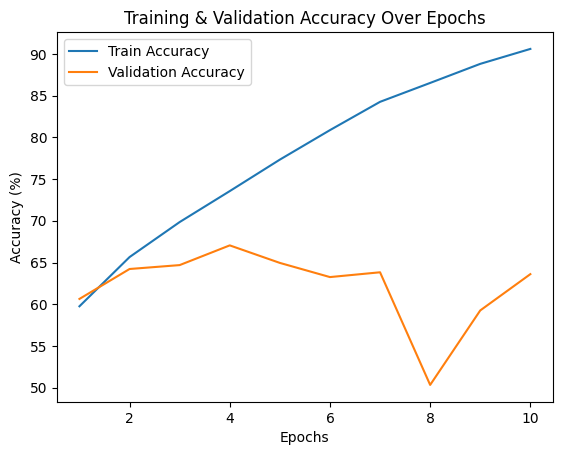

In [22]:
# Plot Accuracy Curves
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()
plt.show()

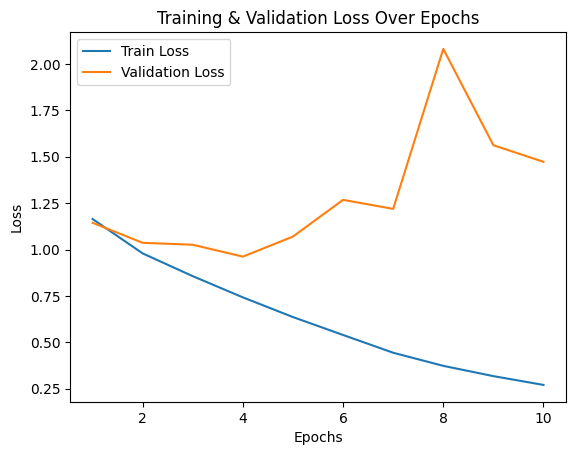

In [23]:
# Plot Loss Curves
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.show()

In [24]:
# Compute Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
if small_dataset is not None:
    class_names = dataset.dataset.classes
else:
    class_names = dataset.classes

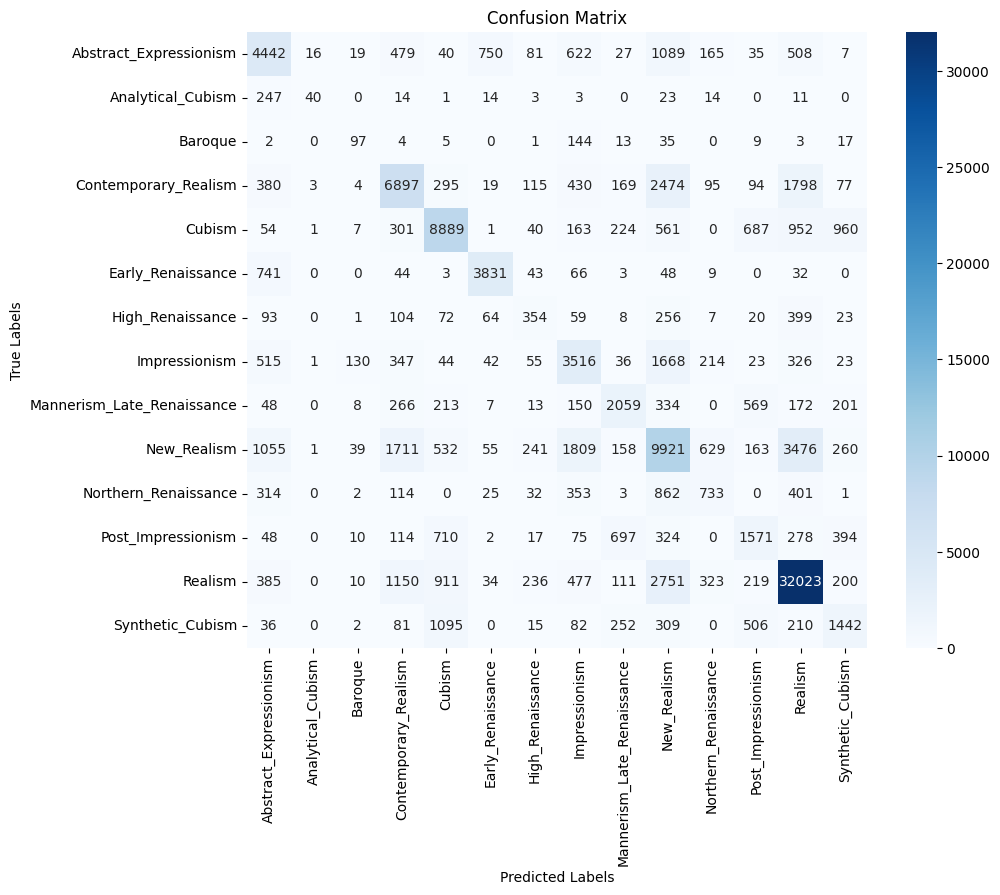

In [25]:
# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Initialize counters for each class
num_classes = len(data_folders)

correct_per_class = np.zeros(num_classes)
total_per_class = np.zeros(num_classes)

# Count correct predictions for each class
for label, pred in zip(all_labels, all_preds):
    total_per_class[label] += 1
    correct_per_class[label] += (pred == label)

# Compute accuracy for each class (avoid division by zero)
accuracy_per_class = np.where(total_per_class > 0, (correct_per_class / total_per_class) * 100, 0)

In [ ]:
# Define class names (update with actual class names if available)
class_names = data_folders  # Replace with real class names

plt.figure(figsize=(10, 6))
plt.bar(class_names, accuracy_per_class, color = sns.color_palette("tab10", len(class_names)) )

plt.xlabel("Class")
plt.ylabel("Accuracy (%)")
plt.title("Classification Accuracy per Class")
plt.xticks(rotation=45)  # Rotate labels for readability
plt.ylim(0, 100)  # Keep accuracy between 0 and 100%
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

### Save/Load state_dict (Recommended)

In [26]:
torch.save(model.state_dict(), 'googlenet_v1.pt')

In [8]:
# You must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. 
# Failing to do this will yield inconsistent inference results
model = models.googlenet(pretrained=True)
# Modify the final fully connected (fc) layer to match saved model
model.fc = torch.nn.Linear(in_features=1024, out_features=len(data_folders))
model.load_state_dict(torch.load('googlenet_v1.pt', map_location=torch.device("cpu")))
# model.eval()

c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [15]:
# Recompute all_preds and all_labels
# pass the validation/test dataset through the model again

# Define transformations (resizing and normalization)
image_size = (128, 128)

transform = transforms.Compose([
    transforms.Resize(image_size),  # Resize images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [16]:
# Store predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():  # No gradient computation needed
    for images, labels in val_loader:
        images, labels = images.to("cpu"), labels.to("cpu")  # Ensure correct device
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted class indices
        
        all_preds.extend(preds.tolist())  # Convert tensor to list
        all_labels.extend(labels.tolist())  # Convert tensor to list

c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\PIL\Image.py:3176: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [17]:
# Initialize counters for each class
num_classes = len(data_folders)

correct_per_class = np.zeros(num_classes)
total_per_class = np.zeros(num_classes)

# Count correct predictions for each class
for label, pred in zip(all_labels, all_preds):
    total_per_class[label] += 1
    correct_per_class[label] += (pred == label)

# Compute accuracy for each class (avoid division by zero)
accuracy_per_class = np.where(total_per_class > 0, (correct_per_class / total_per_class) * 100, 0)

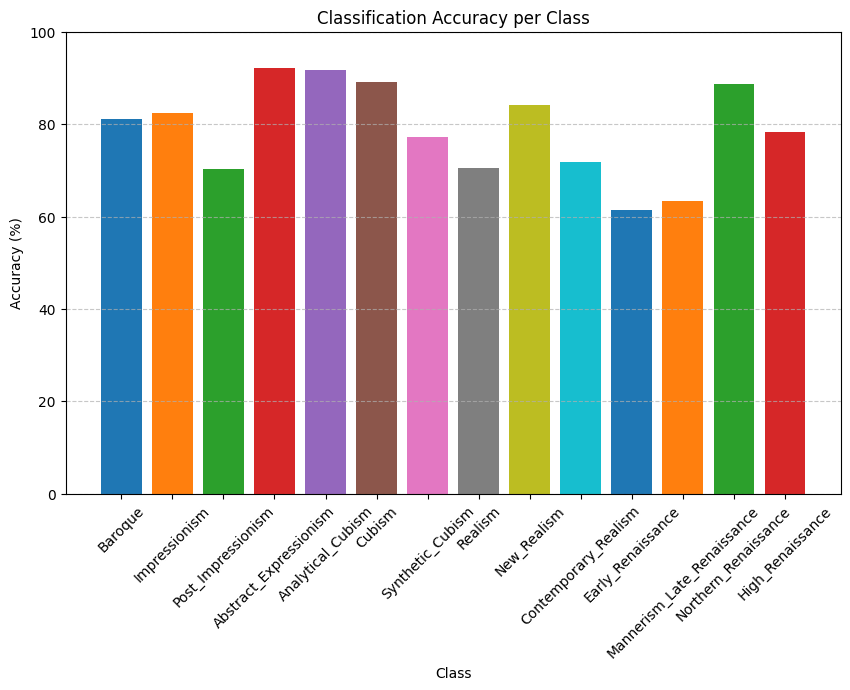

In [23]:
# Define class names (update with actual class names if available)
class_names = data_folders  # Replace with real class names

plt.figure(figsize=(10, 6))
plt.bar(class_names, accuracy_per_class, color = sns.color_palette("tab10", len(class_names)) )

plt.xlabel("Class")
plt.ylabel("Accuracy (%)")
plt.title("Classification Accuracy per Class")
plt.xticks(rotation=45)  # Rotate labels for readability
plt.ylim(0, 100)  # Keep accuracy between 0 and 100%
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()